In [1]:
import models
import numpy as np
import jax.numpy as jnp
import objax
import jax
import data
import util
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [21]:
def cm_plot(cm):
    labels = ['Annual Crop', 'Forest', 'Herbaceous Vegetation', 'Highway',
              'Industrial Buildings', 'Pasture', 'Permanent Crop',
              'Residential Buildings', 'River', 'Sea & Lake']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels)    
    return disp.plot(include_values=True,
                     cmap='viridis', ax=None, xticks_rotation='vertical',
                     values_format=None)

def save_plot(y_true, y_pred, title, fname):
    plot = cm_plot(confusion_matrix(y_true, y_pred))
    plot.figure_.suptitle(title)
    plot.figure_.savefig(fname, bbox_inches='tight', transparent=True)
    
def save_sub_model_plots(logits, y_true, title_template, fname_template):
    for m in range(4):
        print("model", m)
        y_pred = jnp.argmax(logits[m], axis=-1)        
        num_correct = np.equal(y_pred, y_true).sum()
        num_total = len(y_true)
        print("accuracy %0.3f" % float(num_correct / num_total))
        save_plot(y_true, y_pred, title_template % m, fname_template % m)

# baseline model

In [3]:
# best siso model
net = models.NonEnsembleNet(num_classes=10,
                            max_conv_size=213,
                            dense_kernel_size=73,
                            seed=0)
objax.io.load_var_collection('saved_models/12_full_rerun/20200915_211949/ckpt/0000000026.npz', net.vars())

In [10]:
logits = []
y_true = []
for imgs, labels in data.test_dataset(batch_size=100): 
    logits.append(net.logits(imgs, single_result=False, logits_dropout=False))
    y_true.extend(labels)
logits = jnp.stack(logits)         
logits = logits.reshape((2700, 10))
logits.shape

(2700, 10)


In [11]:
y_pred = jnp.argmax(logits, axis=-1)
y_pred.shape

(2700,)

# ensemble models

In [27]:
def print_validation_test_accuracy(net):
    print("validation %0.3f" % util.accuracy(net, data.validation_dataset(batch_size=100)))
    print("test %0.3f" % util.accuracy(net, data.test_dataset(batch_size=100)))
    
def logits_and_y_true_for_test_set(net):
    logits = []
    y_true = []
    for imgs, labels in data.test_dataset(batch_size=100): 
        logits.append(net.logits(imgs, single_result=False, logits_dropout=False))
        y_true.extend(labels)
    logits = jnp.stack(logits)              # (27, M, 100, 10)
    logits = logits.transpose((1,0,2,3))    # (M, 27, 100, 10)
    logits = logits.reshape((4, 2700, 10))  # (M, 2700, 10)
    return logits, y_true

## simo

In [22]:
# best simo model
net = models.EnsembleNet(num_models=4,
                         num_classes=10,
                         max_conv_size=127,
                         dense_kernel_size=112,
                         seed=0)
objax.io.load_var_collection('saved_models/12_full_rerun/20200915_230349/ckpt/0000000029.npz', net.vars())

print_validation_test_accuracy(net)

validation 0.920
test 0.901


In [28]:
logits, y_true = logits_and_y_true_for_test_set(net)

y_pred = jnp.argmax(logits.sum(axis=0), axis=-1)
y_pred.shape

(2700,)

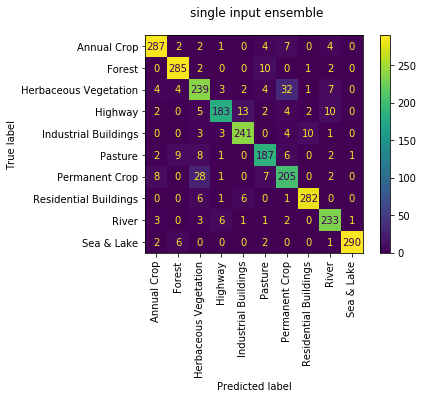

In [29]:
save_plot(y_true, y_pred, "single input ensemble", "/tmp/cm.simo.ensemble.png")

model 0
accuracy 0.111
model 1
accuracy 0.634
model 2
accuracy 0.157
model 3
accuracy 0.686


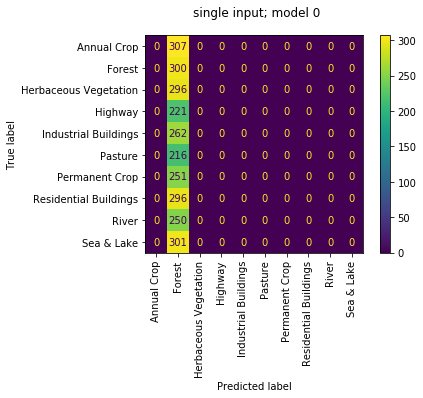

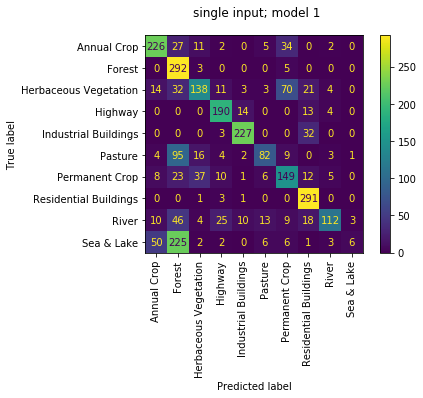

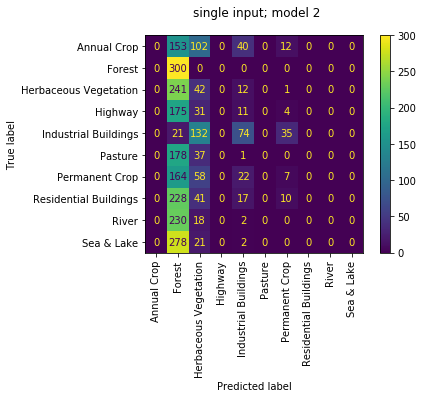

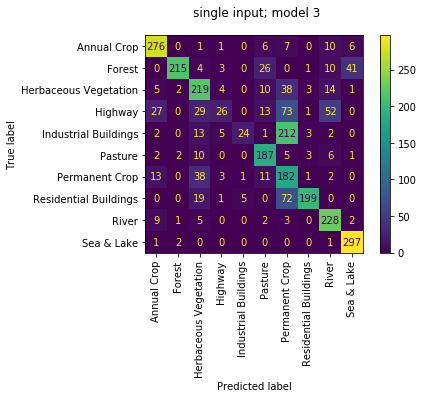

In [32]:
save_sub_model_plots(logits, y_true, "single input; model %d", "/tmp/cm.simo.model_%d.png")

## mimo

In [33]:
# best mimo model
net = models.EnsembleNet(num_models=4,
                         num_classes=10,
                         max_conv_size=137,
                         dense_kernel_size=115,
                         seed=0)
objax.io.load_var_collection('saved_models/12_full_rerun/20200916_024542/ckpt/0000000039.npz', net.vars())  

In [34]:
print_validation_test_accuracy(net)

validation 0.902
test 0.896


In [35]:
logits, y_true = logits_and_y_true_for_test_set(net)

y_pred = jnp.argmax(logits.sum(axis=0), axis=-1)
y_pred.shape

(2700,)

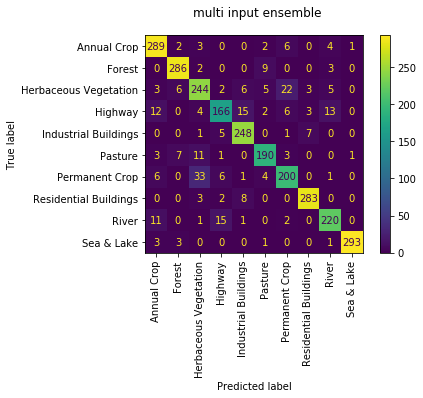

In [36]:
save_plot(y_true, y_pred, "multi input ensemble", "/tmp/cm.mimo.ensemble.png")

model 0
accuracy 0.842
model 1
accuracy 0.857
model 2
accuracy 0.850
model 3
accuracy 0.850


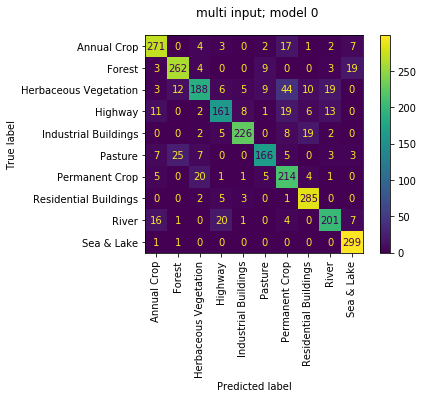

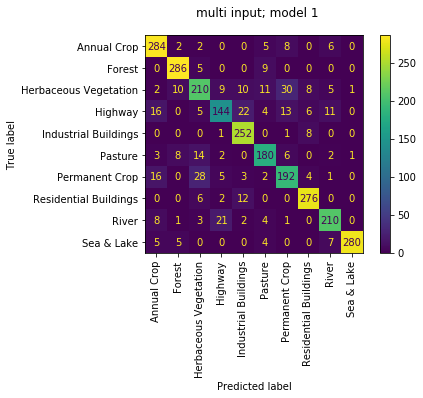

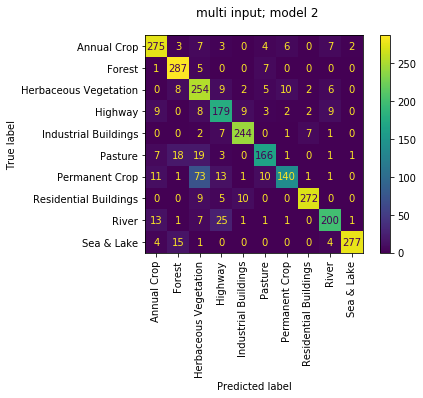

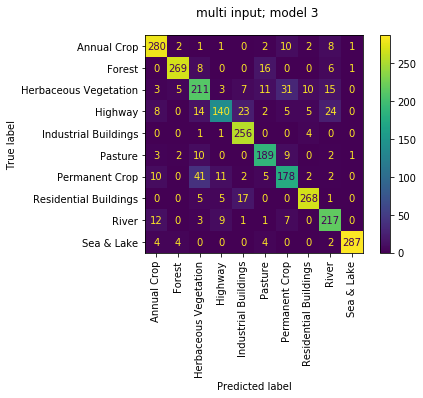

In [37]:
save_sub_model_plots(logits, y_true, "multi input; model %d", "/tmp/cm.mimo.model_%d.png")

## simo_ld

In [38]:
# best simo_ld model
net = models.EnsembleNet(num_models=4,
                         num_classes=10,
                         max_conv_size=256,
                         dense_kernel_size=38,
                         seed=0)
objax.io.load_var_collection('saved_models/12_full_rerun/20200916_012048/ckpt/0000000027.npz', net.vars())

In [39]:
print_validation_test_accuracy(net)

validation 0.914
test 0.911


In [40]:
logits, y_true = logits_and_y_true_for_test_set(net)

y_pred = jnp.argmax(logits.sum(axis=0), axis=-1)
y_pred.shape

(2700,)

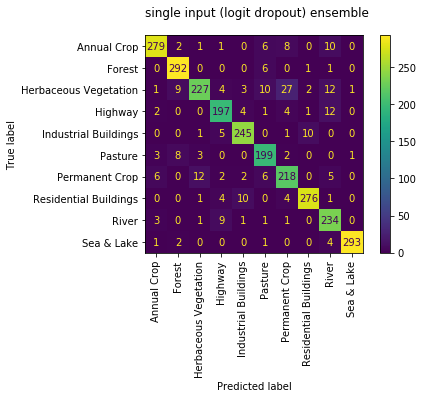

In [41]:
save_plot(y_true, y_pred, "single input (logit dropout) ensemble", "/tmp/cm.simo_ld.ensemble.png")

model 0
accuracy 0.764
model 1
accuracy 0.827
model 2
accuracy 0.772
model 3
accuracy 0.710


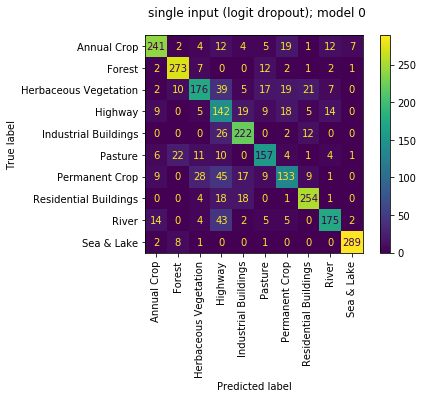

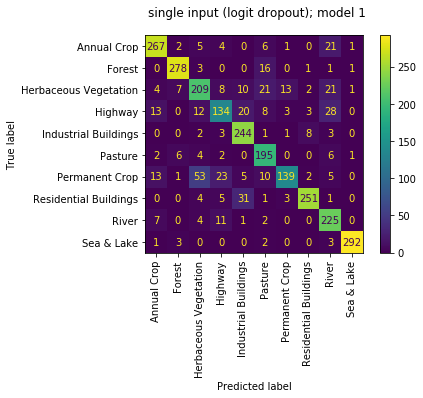

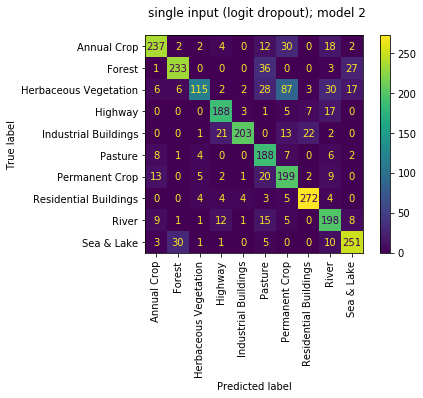

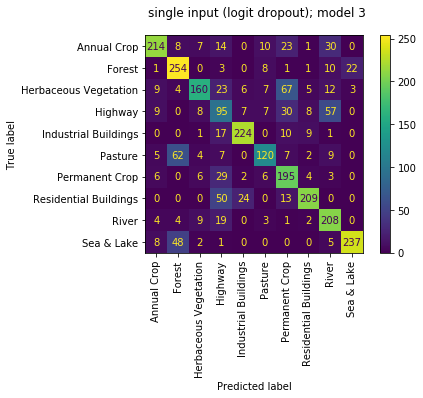

In [42]:
save_sub_model_plots(logits, y_true, "single input (logit dropout); model %d", "/tmp/cm.simo_ld.model_%d.png")